# MODEL 2: Predicting Human Preference Between model_a and model_b
##### (Note: Model A and Model B do not specify a specific model (e.g. GPT-4 vs Claude, etc.). Rather, we are looking to understand human preferences using Model A as the "default" or the benchmark)

In [2]:
!pip install textblob
!python -m textblob.download_corpora

  Using cached textblob-0.19.0-py3-none-any.whl.metadata (4.4 kB)
Using cached textblob-0.19.0-py3-none-any.whl (624 kB)
[nltk_data] Downloading package brown to /srv/conda/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /srv/conda/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /srv/conda/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /srv/conda/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /srv/conda/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /srv/conda/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [3]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load the data
df = pd.read_csv("ieor142a_sampled_dataset - Master Sheet.csv")

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Clean up category values
df['open/closed'] = df['open/closed'].str.strip().str.capitalize()
df['domain'] = df['domain'].str.strip().str.capitalize()

# Drop rows where winner is a tie or bothbad
df = df[df['winner'].isin(['model_a', 'model_b'])]

In [5]:
# Create binary target: 1 if human preferred model_a, else 0
df['winner_binary'] = (df['winner'] == 'model_a').astype(int)

In [6]:
# Structural features
df['prompt_length'] = df['prompt'].apply(lambda x: len(str(x).split()))
df['response_a_length'] = df['response_a'].apply(lambda x: len(str(x).split()))
df['response_b_length'] = df['response_b'].apply(lambda x: len(str(x).split()))
df['response_length_diff'] = np.abs(df['response_a_length'] - df['response_b_length'])

# Sentiment features
def get_sentiment(text):
    if pd.isna(text):
        return 0
    return TextBlob(str(text)).sentiment.polarity

df['sentiment_a'] = df['response_a'].apply(get_sentiment)
df['sentiment_b'] = df['response_b'].apply(get_sentiment)
df['sentiment_diff'] = df['sentiment_a'] - df['sentiment_b']

# Define features
categorical_features = ['open/closed', 'domain']
numeric_features = [
    'prompt_length',
    'response_length_diff',
    'sentiment_a',
    'sentiment_b',
    'sentiment_diff'
]

In [7]:
# Drop any rows with missing features
df = df.dropna(subset=categorical_features + numeric_features)

X = df[categorical_features + numeric_features]
y = df['winner_binary']

In [8]:
# Preprocessing
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numeric_features)
])

# Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['open/closed', 'domain']),
                                                 ('num', StandardScaler(),
                                                  ['prompt_length',
                                                   'response_length_diff',
                                                   'sentiment_a', 'sentiment_b',
                                                   'sentiment_diff'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

Human Preference Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.11      0.18        46
           1       0.44      0.86      0.58        37

    accuracy                           0.45        83
   macro avg       0.47      0.49      0.38        83
weighted avg       0.47      0.45      0.36        83

Confusion Matrix:
 [[ 5 41]
 [ 5 32]]


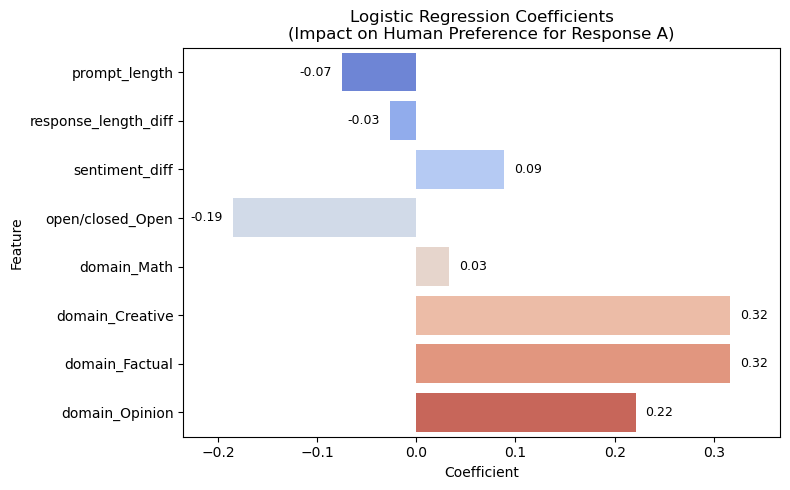

In [12]:
# Evaluate
y_pred = pipeline.predict(X_test)
print("Human Preference Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Extract coefficient names
ohe = pipeline.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(categorical_features).tolist()
feature_names = encoded_cat_features + numeric_features

# Create dataframe
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': pipeline.named_steps['classifier'].coef_[0]
})

# Optional: sort by absolute value for reference
coef_df['abs_coef'] = coef_df['Coefficient'].abs()

# Reorder features by your specified logic
ordered_features = [
    'prompt_length',
    'response_length_diff',
    'sentiment_diff',
    'open/closed_Open',
    'domain_Math',
    'domain_Creative',
    'domain_Factual',
    'domain_Opinion'
]

# Filter and reorder
coef_df = coef_df.set_index('Feature').loc[ordered_features].reset_index()

# Create plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=coef_df,
    hue='Feature',
    dodge=False,
    palette='coolwarm',
    legend=False,
    ax=ax
)

# Annotate each bar with its coefficient value
for i, row in coef_df.iterrows():
    coef = row['Coefficient']
    ax.text(
        x=coef + 0.01 if coef > 0 else coef - 0.01,
        y=i,
        s=f"{coef:.2f}",
        va='center',
        ha='left' if coef > 0 else 'right',
        fontsize=9
    )

# Expand x-axis limits to prevent cutoff
buffer = 0.05
min_coef = coef_df['Coefficient'].min()
max_coef = coef_df['Coefficient'].max()
ax.set_xlim(min_coef - buffer, max_coef + buffer)

# Final plot formatting
ax.set_title("Logistic Regression Coefficients\n(Impact on Human Preference for Response A)")
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
plt.tight_layout()
plt.show()